# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 7e-4

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2023-09-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-09-01 00:00:00', tz='UTC')

In [4]:

groups = [
    'Forex_Indicator',
    'CryptoCross_grp',
    'Crypto_group',
    'Energies_group',
    'Forex_group',
    'Indices_group',
    'Stocks_group'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if ('Energies_group' in symbol.path or 'Indices_group' in symbol.path or 'Stocks_group' in symbol.path)]

print(tickers)

intervals = [
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H2,
    # mt5.TIMEFRAME_H1,
    # mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['UKOILm', 'USOILm', 'AUS200m', 'DE30m', 'FR40m', 'HK50m', 'JP225m', 'STOXX50m', 'UK100m', 'US30m', 'US500m', 'USTECm', 'AAPLm', 'ABBVm', 'ABTm', 'ADBEm', 'ADPm', 'AMDm', 'AMGNm', 'AMTm', 'AMZNm', 'ATVIm', 'AVGOm', 'BAm', 'BABAm', 'BACm', 'BIIBm', 'BMYm', 'Cm', 'CHTRm', 'CMCSAm', 'CMEm', 'COSTm', 'CSCOm', 'CSXm', 'CVSm', 'EAm', 'EBAYm', 'EQIXm', 'Fm', 'FBm', 'GILDm', 'GOOGLm', 'HDm', 'IBMm', 'INTCm', 'INTUm', 'ISRGm', 'JNJm', 'JPMm', 'KOm', 'LINm', 'LLYm', 'LMTm', 'MAm', 'MCDm', 'MDLZm', 'MMMm', 'MOm', 'MRKm', 'MSm', 'MSFTm', 'NFLXm', 'NKEm', 'NVDAm', 'ORCLm', 'PEPm', 'PFEm', 'PGm', 'PMm', 'PYPLm', 'REGNm', 'SBUXm', 'Tm', 'TMOm', 'TMUSm', 'TSLAm', 'UNHm', 'UPSm', 'Vm', 'VRTXm', 'VZm', 'WFCm', 'WMTm', 'XOMm', 'AMCm', 'BBm', 'BBBYm', 'BEKEm', 'BIDUm', 'BILIm', 'BRQSm', 'BYNDm', 'CANm', 'EDUm', 'FTNTm', 'FUTUm', 'IQm', 'JDm', 'LIm', 'NIOm', 'NTESm', 'PDDm', 'RLXm', 'TALm', 'TIGRm', 'TMEm', 'TSMm', 'VIPSm', 'XPEVm', 'YUMCm', 'ZTOm', 'XNGUSDm', 'METAm', 'IN50m']
MetaTrader5 package author: 

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


intervals_start_dates

print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16388: Timestamp('2022-03-20 20:00:00+0000', tz='UTC'), 16386: Timestamp('2022-03-20 22:00:00+0000', tz='UTC')}
2023-09-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


# Estrategia

In [7]:
from backbone.bbands_cross_strategy import BbandsCross

STRATEGY = BbandsCross

# Analisis preliminar

In [8]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


AAPLm 16388
AAPLm 16386
ABBVm 16388
ABBVm 16386
ABTm 16388
ABTm 16386
ADBEm 16388
ADBEm 16386
ADPm 16388
ADPm 16386
AMDm 16388
AMDm 16386
AMGNm 16388
AMGNm 16386
AMTm 16388
AMTm 16386
AMZNm 16388
AMZNm 16386
AUS200m 16388
AUS200m 16386
AVGOm 16388
AVGOm 16386
BABAm 16388
BABAm 16386
BACm 16388
BACm 16386
BAm 16388
BAm 16386
BBm 16388
BBm 16386
BEKEm 16388
BEKEm 16386
BIDUm 16388
BIDUm 16386
BIIBm 16388
BIIBm 16386
BILIm 16388
BILIm 16386
BMYm 16388
BMYm 16386
CHTRm 16388
CHTRm 16386
CMCSAm 16388
CMCSAm 16386
CMEm 16388
CMEm 16386
COSTm 16388
COSTm 16386
CSCOm 16388
CSCOm 16386
CSXm 16388
CSXm 16386
CVSm 16388
CVSm 16386
Cm 16388
Cm 16386
DE30m 16388
DE30m 16386
EAm 16388
EAm 16386
EBAYm 16388
EBAYm 16386
EDUm 16388
EDUm 16386
EQIXm 16388
EQIXm 16386
FBm 16388
FBm 16386
FR40m 16388
FR40m 16386
FTNTm 16388
FTNTm 16386
FUTUm 16388
FUTUm 16386
Fm 16388
Fm 16386
GILDm 16388
GILDm 16386
GOOGLm 16388
GOOGLm 16386
HDm 16388
HDm 16386
HK50m 16388
HK50m 16386
IBMm 16388
IBMm 16386
INTCm 16388
IN

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:84: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:84: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


JPMm 16388
JPMm 16386
KOm 16388
KOm 16386
LINm 16388
LINm 16386
LIm 16388
LIm 16386
LLYm 16388
LLYm 16386
LMTm 16388
LMTm 16386
MAm 16388
MAm 16386
MCDm 16388
MCDm 16386
MDLZm 16388
MDLZm 16386
METAm 16388
METAm 16386
MMMm 16388
MMMm 16386
MOm 16388
MOm 16386
MRKm 16388
MRKm 16386
MSFTm 16388
MSFTm 16386
MSm 16388
MSm 16386
NFLXm 16388
NFLXm 16386
NIOm 16388
NIOm 16386
NKEm 16388
NKEm 16386
NTESm 16388
NTESm 16386
NVDAm 16388
NVDAm 16386
ORCLm 16388
ORCLm 16386
PDDm 16388
PDDm 16386
PEPm 16388
PEPm 16386
PFEm 16388
PFEm 16386
PGm 16388
PGm 16386
PMm 16388
PMm 16386
PYPLm 16388
PYPLm 16386
REGNm 16388
REGNm 16386
RLXm 16388
RLXm 16386
SBUXm 16388
SBUXm 16386
STOXX50m 16388
STOXX50m 16386
TALm 16388
TALm 16386
TMEm 16388
TMEm 16386
TMOm 16388
TMOm 16386
TMUSm 16388
TMUSm 16386
TSLAm 16388
TSLAm 16386
TSMm 16388
TSMm 16386
Tm 16388
Tm 16386
UK100m 16388
UK100m 16386
UKOILm 16388
UKOILm 16386
UNHm 16388
UNHm 16386
UPSm 16388
UPSm 16386
US30m 16388
US30m 16386
US500m 16388
US500m 16386
USOI

In [9]:

filter_performance = performance[
    (performance['return/dd']>2)
    & (performance['stability_ratio']>0.7)
].sort_values(by=['return/dd'], ascending=[False]).drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,BbandsCross,KOm,16386,0.900788,2.869802,10286.980242,0.338708,20 days 18:00:00,85.714286,1.926737,7,0.836125,5.700000,10286.980242,364 days 06:00:00,8.472781,4.457719
0,BbandsCross,ADBEm,16388,0.920584,2.100556,10210.055561,0.291360,86 days 00:00:00,100.000000,2.496280,4,3.160354,5.119454,10210.055561,364 days 04:00:00,7.209482,2.617948
0,BbandsCross,INTUm,16388,0.876990,2.002684,10200.268415,0.309037,7 days 04:00:00,75.000000,1.942298,4,2.003259,6.313993,10200.268415,364 days 04:00:00,6.480402,2.462265
0,BbandsCross,METAm,16388,0.875354,1.405826,10140.582590,0.220055,128 days 08:00:00,100.000000,1.605390,2,3.921784,1.913876,10140.582590,364 days 08:00:00,6.388506,1.265891
0,BbandsCross,CHTRm,16388,0.860883,4.110196,10411.019632,0.656978,27 days 00:00:00,100.000000,1.353155,4,5.353357,9.897611,10411.019632,364 days 04:00:00,6.256219,3.992272
0,BbandsCross,INTCm,16388,0.957106,4.635170,10463.517028,0.954113,72 days 08:00:00,100.000000,2.636756,9,2.838633,13.277512,10463.517028,364 days 08:00:00,4.858092,5.461748
0,BbandsCross,EDUm,16386,0.758319,5.247305,10524.730467,1.105703,42 days 00:00:00,83.333333,1.160530,6,4.196931,11.700000,10524.730467,364 days 06:00:00,4.745672,4.849109
0,BbandsCross,CMCSAm,16386,0.938501,3.463022,10346.302159,0.742337,52 days 22:00:00,90.000000,1.961481,10,1.107406,9.000000,10346.302159,364 days 06:00:00,4.665026,4.765991
0,BbandsCross,FTNTm,16388,0.855902,1.755718,10175.571820,0.396189,12 days 00:00:00,100.000000,1.872872,4,3.518385,7.153076,10175.571820,364 days 04:00:00,4.431517,2.023880
0,BbandsCross,SBUXm,16388,0.872593,1.764077,10176.407670,0.400846,18 days 00:00:00,80.000000,1.685882,5,1.698098,6.996587,10176.407670,364 days 04:00:00,4.400880,2.256351


In [10]:
for ticker, interval in zip(portfolio, intervals):
    
    prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

    
    df_stats = run_strategy(
        strategy=STRATEGY,
        ticker=ticker,
        interval=interval,
        commission=COMMISSION, 
        prices=prices, 
        initial_cash=INITIAL_CASH, 
        margin=MARGIN,
        plot=True
    )
    break


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


# WFO

In [11]:
lookback_bars_per_interval = {
    16388: 1200,
    16386: 1800,
}

In [12]:
from backbone.utils.wfo_utils import optimization_function

validation_bars = 200
warmup_bars = 200

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'bband_std' : list(np.arange(1, 3, 0.2)),
    'atr_multiplier':list(np.arange(1, 5, 0.3).round(2)),
}

for index, row in filter_performance.iterrows():
    
    try:
        ticker = row.ticker
        interval = row.interval
        
        lookback_bars = lookback_bars_per_interval[interval]
        
        print(ticker, interval)
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

KOm 16386
ADBEm 16388
INTUm 16388
METAm 16388
CHTRm 16388
INTCm 16388
EDUm 16386
CMCSAm 16386
FTNTm 16388
SBUXm 16388
FBm 16388
PYPLm 16388
JPMm 16388
TMEm 16386
MSm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


PFEm 16388
MCDm 16386
BILIm 16386
ABBVm 16386
VZm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


GILDm 16386
UNHm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


FR40m 16386
US500m 16386
BBm 16388
USTECm 16388


In [31]:
for k, v in params.items():
    v['risk'] = 10

params

{Timestamp('2022-09-19 20:00:00+0000', tz='UTC'): {'bband_std': 1.2,
  'atr_multiplier': 1.0,
  'minimum_units': 1.0,
  'maximum_units': 50000.0,
  'contract_volume': 100.0,
  'pip_value': 0.0001,
  'risk': 30},
 Timestamp('2022-11-04 04:00:00+0000', tz='UTC'): {'bband_std': 1.2,
  'atr_multiplier': 1.0,
  'minimum_units': 1.0,
  'maximum_units': 50000.0,
  'contract_volume': 100.0,
  'pip_value': 0.0001,
  'risk': 30},
 Timestamp('2022-12-20 16:00:00+0000', tz='UTC'): {'bband_std': 1.2,
  'atr_multiplier': 1.3,
  'minimum_units': 1.0,
  'maximum_units': 50000.0,
  'contract_volume': 100.0,
  'pip_value': 0.0001,
  'risk': 30},
 Timestamp('2023-02-06 20:00:00+0000', tz='UTC'): {'bband_std': 1.2,
  'atr_multiplier': 1.3,
  'minimum_units': 1.0,
  'maximum_units': 50000.0,
  'contract_volume': 100.0,
  'pip_value': 0.0001,
  'risk': 30},
 Timestamp('2023-03-23 08:00:00+0000', tz='UTC'): {'bband_std': 1.2,
  'atr_multiplier': 1.3,
  'minimum_units': 1.0,
  'maximum_units': 50000.0,
  'con

In [32]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        prices = symbols[ticker][interval]
        params = all_opt_params[ticker][interval]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=False
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


KOm 16386
ADBEm 16388
INTUm 16388
METAm 16388
CHTRm 16388
INTCm 16388
EDUm 16386
CMCSAm 16386
FTNTm 16388
SBUXm 16388
FBm 16388
PYPLm 16388
JPMm 16388
TMEm 16386
MSm 16388
PFEm 16388
MCDm 16386
BILIm 16386
ABBVm 16386
VZm 16388
GILDm 16386
UNHm 16388
FR40m 16386
US500m 16386
BBm 16388
USTECm 16388


In [38]:
filtered_wfo_performance = performance[
    (performance['stability_ratio'] > 0.65)
    & (performance['return/dd'] > 2)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,BbandsCross,JPMm,16388,0.904306,8.911387,10891.138715,1.098750,115 days 00:00:00,100.000000,2.048003,11,2.666239,8.636093,10891.138715,1038 days 00:00:00,8.110475,10.551024
0,BbandsCross,ADBEm,16388,0.840605,9.738421,10973.842145,1.218926,318 days 16:00:00,90.909091,1.433823,11,3.461256,9.291245,10973.842145,1038 days 00:00:00,7.989346,10.905757
0,BbandsCross,SBUXm,16388,0.963450,6.722914,10672.291448,0.939890,245 days 08:00:00,86.666667,1.484372,15,2.254923,12.150089,10672.291448,1038 days 00:00:00,7.152872,9.608728
0,BbandsCross,BBm,16388,0.675831,5.338049,10533.804921,2.168528,168 days 08:00:00,60.000000,0.601890,15,1.390761,10.043197,10533.804921,1038 days 00:00:00,2.461601,4.671007
0,BbandsCross,BILIm,16386,0.674601,13.586902,11358.690222,6.242627,354 days 20:00:00,62.222222,0.894814,45,0.012573,11.961722,11358.690222,1038 days 02:00:00,2.176472,7.182391
0,BbandsCross,PYPLm,16388,0.713439,4.570959,10457.095923,2.190861,273 days 00:00:00,61.904762,0.559297,21,0.689696,11.208699,10457.095923,1038 days 00:00:00,2.086375,4.427967
0,BbandsCross,METAm,16388,0.792107,5.253572,10525.357157,2.552947,238 days 04:00:00,62.500000,0.638755,16,2.698563,7.726901,10525.357157,1064 days 08:00:00,2.057846,4.189336


In [41]:
filtered_wfo_performance.ticker.values

array(['JPMm', 'ADBEm', 'SBUXm', 'BBm', 'BILIm', 'PYPLm', 'METAm'],
      dtype=object)

# Montecarlo

In [34]:
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][interval]._trades
    eq_curve = stats_per_symbol[ticker][interval]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=INITIAL_CASH, 
        threshold_ruin=0.8, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: JPMm
Procesando ticker: ADBEm
Procesando ticker: SBUXm
Procesando ticker: PYPLm
Procesando ticker: METAm


In [35]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_JPMm,drawdown_ADBEm,drawdown_SBUXm,drawdown_PYPLm,drawdown_METAm
count,100000.000000,100000.0,100000.000000,1.000000e+05,0.0
mean,-0.000042,0.0,-0.071434,-4.356830e-07,NaN
std,0.001640,0.0,0.123395,1.015437e-04,NaN
min,-0.152103,0.0,-1.131981,-2.818818e-02,NaN
10%,0.000000,0.0,-0.246461,0.000000e+00,NaN
25%,0.000000,0.0,-0.105250,0.000000e+00,NaN
50%,0.000000,0.0,0.000000,0.000000e+00,NaN
75%,0.000000,0.0,0.000000,0.000000e+00,NaN
90%,0.000000,0.0,0.000000,0.000000e+00,NaN
max,0.000000,0.0,0.000000,0.000000e+00,NaN


,return_JPMm,return_ADBEm,return_SBUXm,return_PYPLm,return_METAm
count,100000.000000,100000.000000,100000.000000,100000.000000,0.0
mean,1.812210,1.841367,1.593103,2.262548,NaN
std,0.270967,0.209624,0.639812,0.217775,NaN
min,0.648898,0.893201,-1.039834,1.325833,NaN
10%,1.465589,1.572673,0.776554,1.984024,NaN
25%,1.629656,1.700073,1.158737,2.115223,NaN
50%,1.811846,1.841061,1.592146,2.262412,NaN
75%,1.994956,1.982230,2.022080,2.409848,NaN
90%,2.160581,2.110293,2.417776,2.541874,NaN
max,2.975116,2.732231,4.572738,3.193150,NaN


ValueError: cannot reindex from a duplicate axis

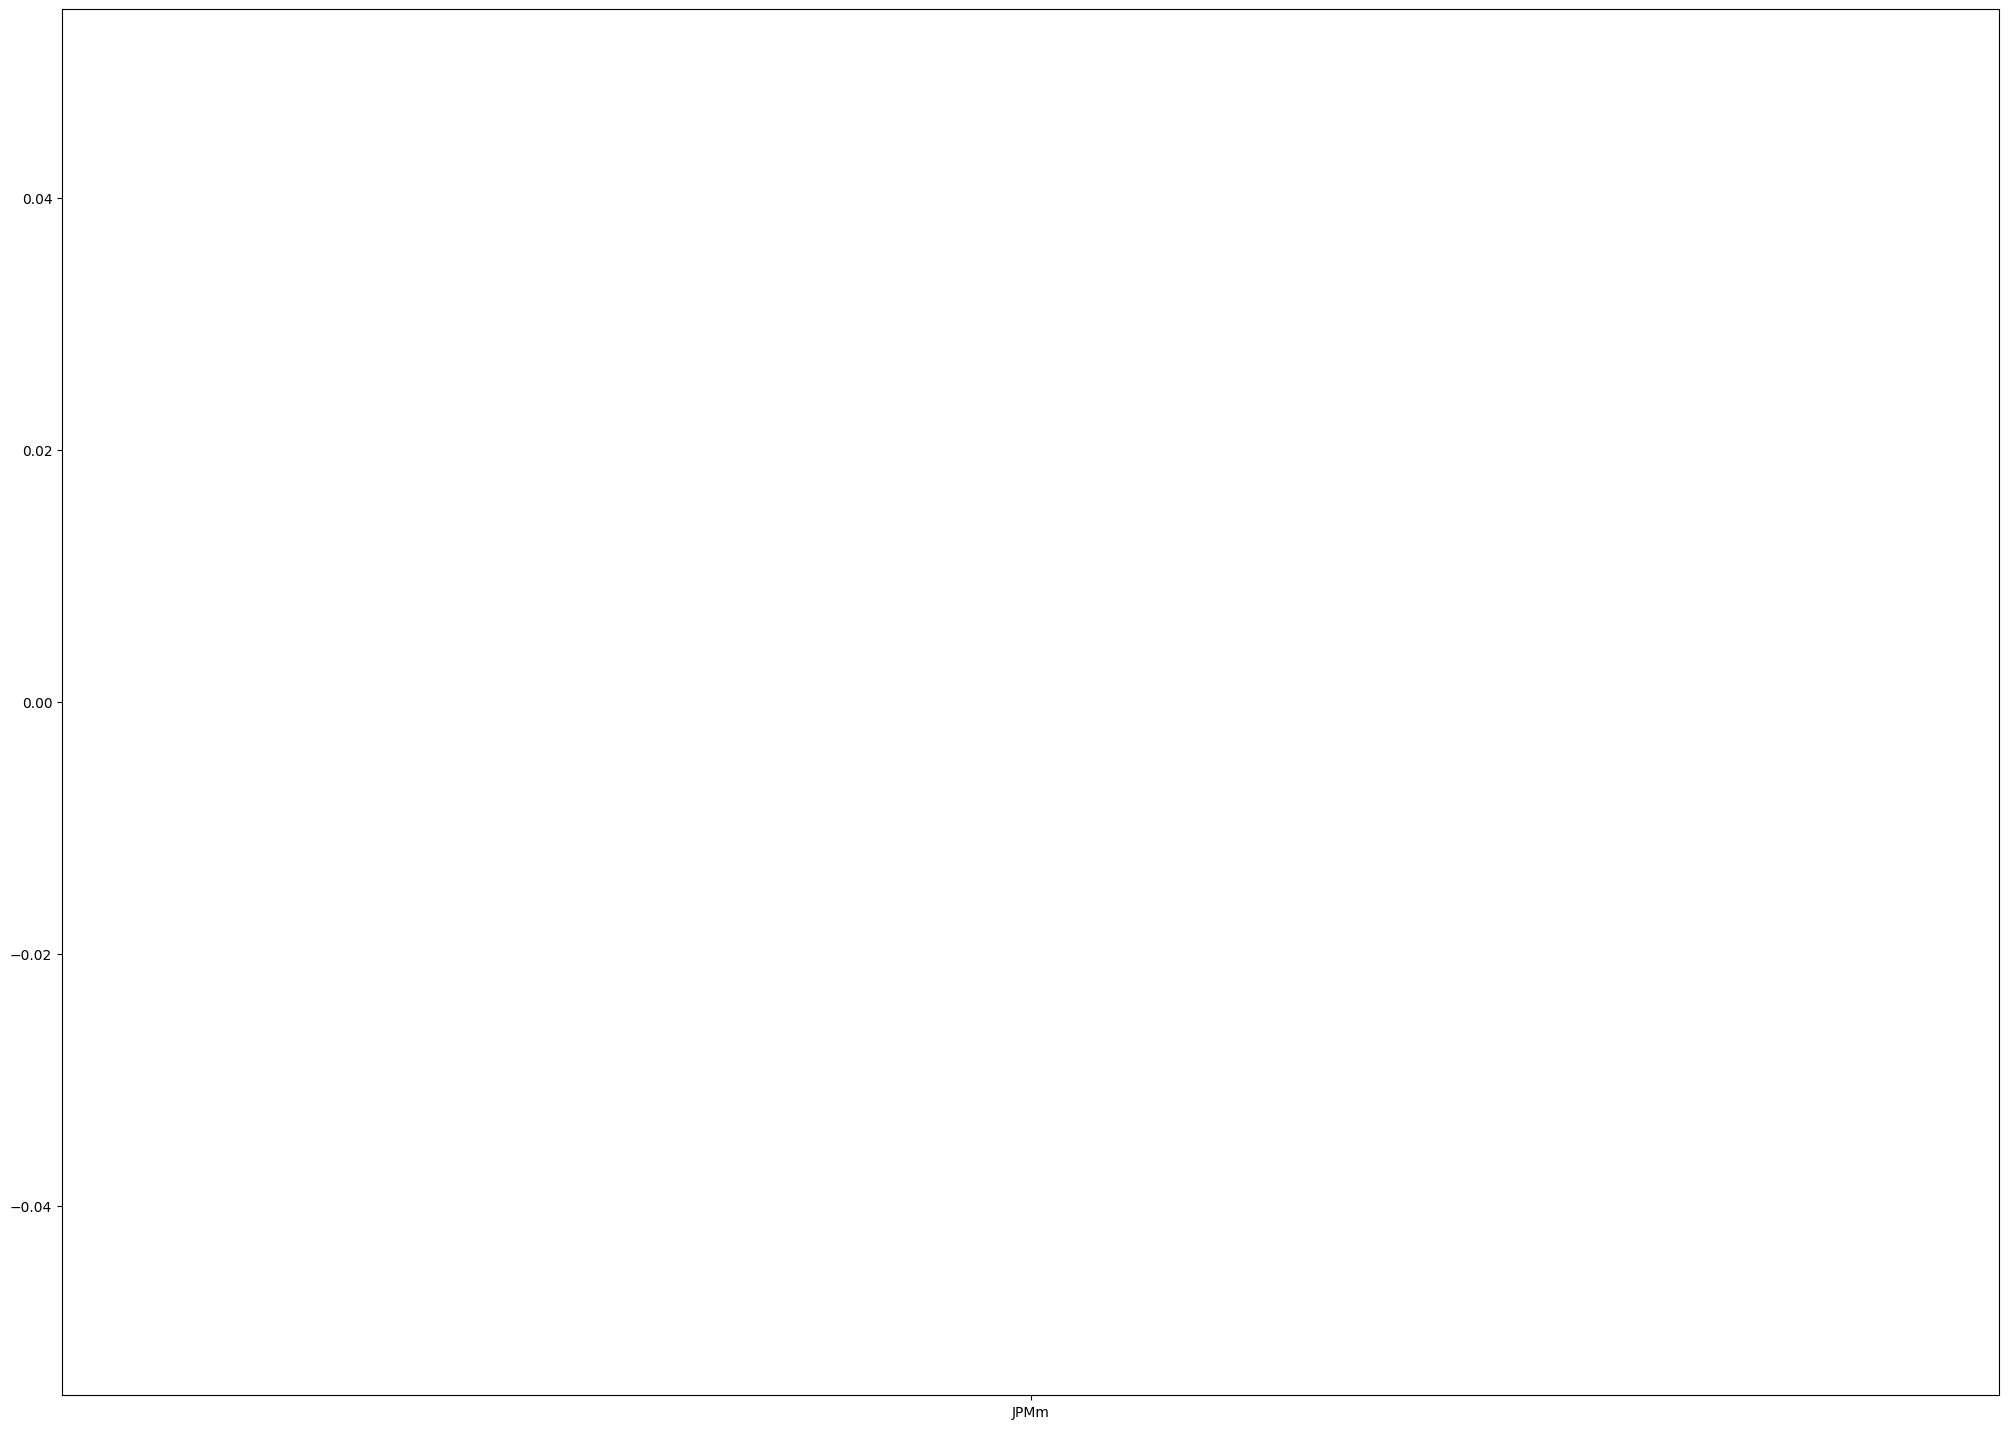

In [36]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


ValueError: cannot reindex from a duplicate axis

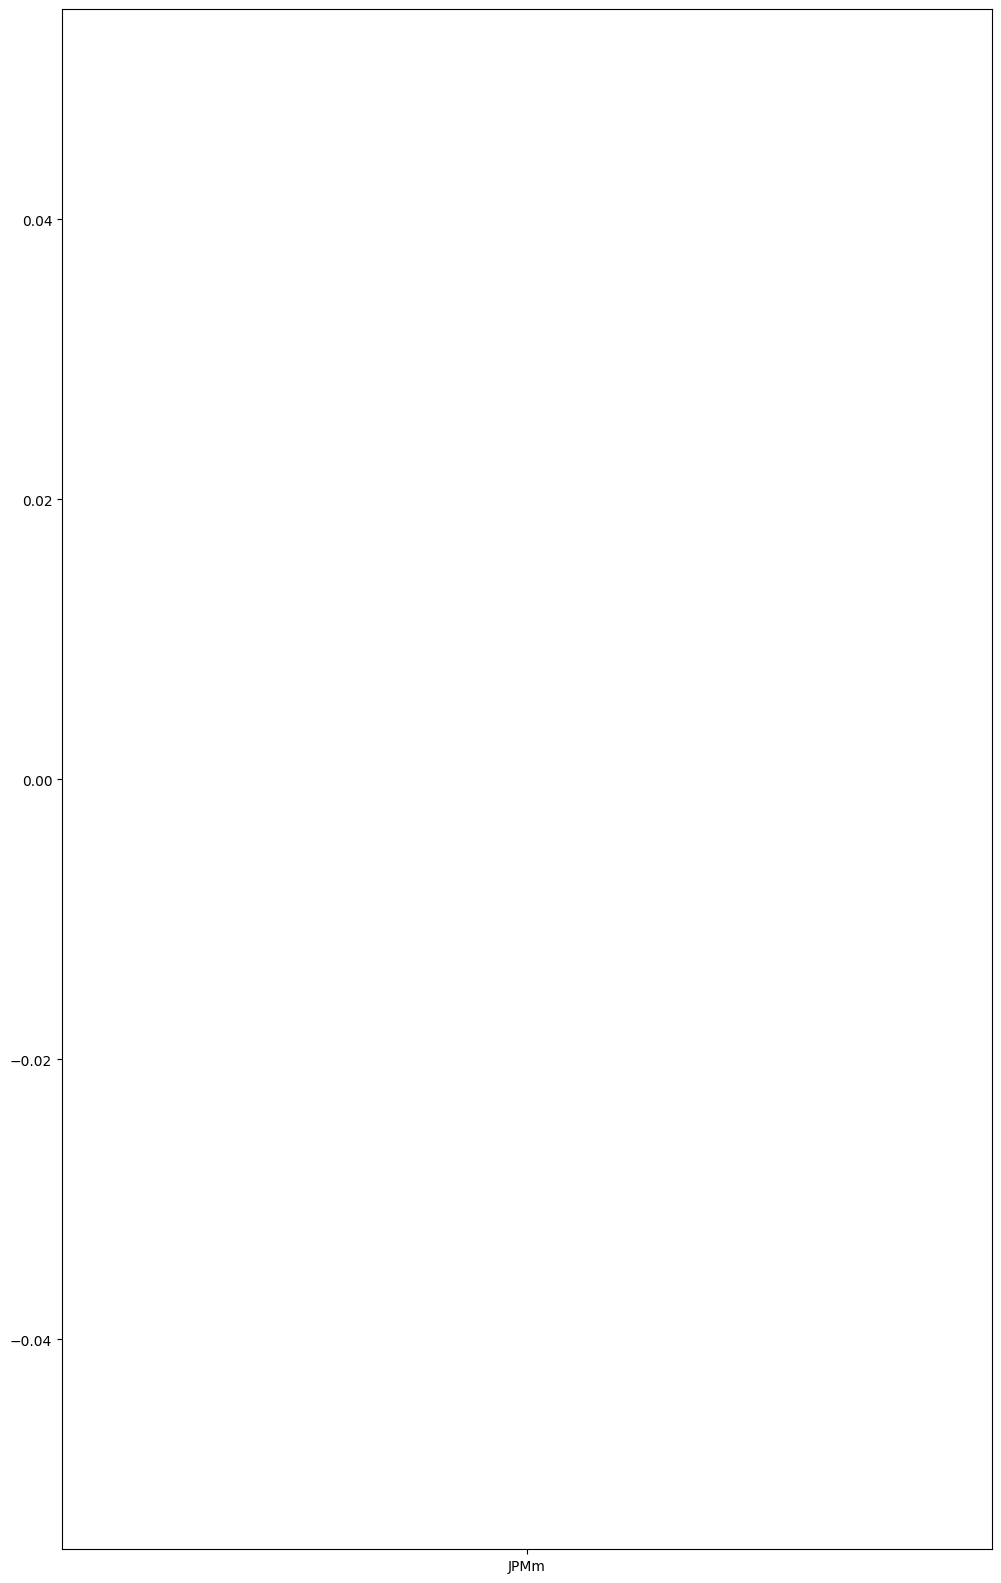

In [37]:
# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
